## Collaborative Filtering on Market Basket Data using Denoising Autoencoder

#### Import required packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

C:\Users\mmata\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Read market basket dataset

In [2]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20','21','22',
        '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("groceries.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
df.head(5)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,citrus fruit,semi-finished bread,margarine,ready soups,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,tropical fruit,yogurt,coffee,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,whole milk,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,pip fruit,yogurt,cream cheese,meat spreads,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,other vegetables,whole milk,condensed milk,long life bakery product,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


#### Helper functions for pre-processing dataset

In [3]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items

def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

In [4]:
unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))

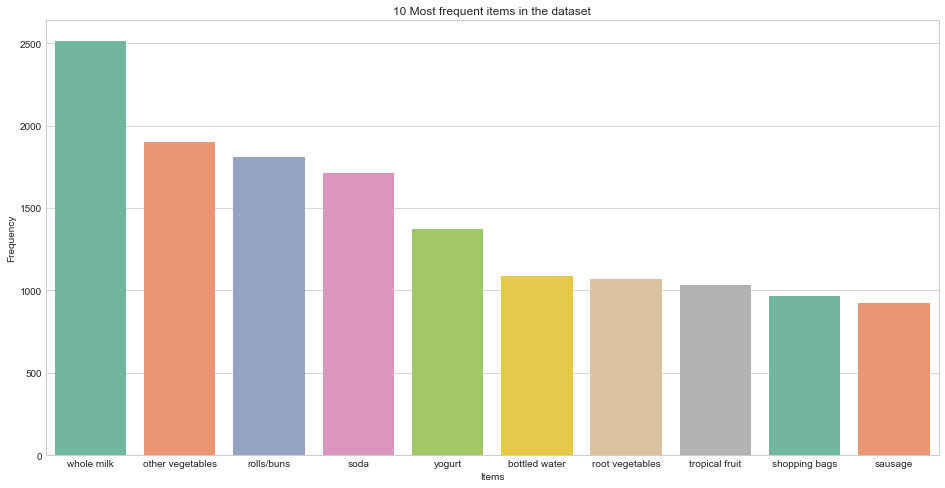

In [5]:
n = 10
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})


fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

#### Split dataset into train, test and validation

In [6]:
train_test_split = np.random.rand(len(onehot_items)) < 0.80
train_x = onehot_items[train_test_split]
test_x = onehot_items[~train_test_split]
print()

train_validation_split = np.random.rand(len(train_x)) < 0.80
validation_x = train_x[~train_validation_split]
train_x = train_x[train_validation_split]

#### Helper functions for defining Denoising Autoencoder (DAE) model

In [7]:
def weight_variable(weight_name, weight_shape):
    return tf.get_variable(name = "weight_" + weight_name,shape = weight_shape, 
            initializer = tf.contrib.layers.xavier_initializer()) 

def bias_variable(bias_shape):
    initial = tf.constant(0.1, shape = bias_shape)
    return tf.Variable(initial)

def encoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,e_weights_h1),e_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,e_weights_h2),e_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,e_weights_h3),e_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,e_weights_h4),e_biases_h4))
    return l4
    
def decoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,d_weights_h1),d_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,d_weights_h2),d_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,d_weights_h3),d_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,d_weights_h4),d_biases_h4))
    return l4

#### Configuration vairables 

In [8]:
input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 10
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.00002
keep_prob = 0.6
l2_reg_rate = 0.00001

#### Defining DAE model architecture and loss function

In [9]:
tf.reset_default_graph()

is_training = tf.placeholder_with_default(False, shape = ())
X = tf.placeholder(tf.float32, shape=[None,input_dim])
X_drop = tf.contrib.layers.dropout(X, keep_prob, is_training = is_training)


# --------------------- Encoder Variables --------------- #

e_weights_h1 = weight_variable("el1",[input_dim, n_hidden_1])
e_biases_h1 = bias_variable([n_hidden_1])

e_weights_h2 = weight_variable("el2",[n_hidden_1, n_hidden_2])
e_biases_h2 = bias_variable([n_hidden_2])

e_weights_h3 = weight_variable("el3",[n_hidden_2, n_hidden_3])
e_biases_h3 = bias_variable([n_hidden_3])

e_weights_h4 = weight_variable("el4",[n_hidden_3, n_hidden_4])
e_biases_h4 = bias_variable([n_hidden_4])

# --------------------------------------------------------- #


# --------------------- Decoder Variables --------------- #

d_weights_h1 = weight_variable("dl1",[n_hidden_4, n_hidden_3])
d_biases_h1 = bias_variable([n_hidden_3])

d_weights_h2 = weight_variable("dl2",[n_hidden_3, n_hidden_2])
d_biases_h2 = bias_variable([n_hidden_2])

d_weights_h3 = weight_variable("dl3",[n_hidden_2, n_hidden_1])
d_biases_h3 = bias_variable([n_hidden_1])

d_weights_h4 = weight_variable("dl4",[n_hidden_1, input_dim])
d_biases_h4 = bias_variable([input_dim])

# --------------------------------------------------------- #

encoded = encoder(X_drop)
decoded = decoder(encoded) 

regularizer = tf.contrib.layers.l2_regularizer(l2_reg_rate)
reg_loss = regularizer(e_weights_h1) + regularizer(e_weights_h2) + regularizer(e_weights_h3) + regularizer(e_weights_h4) 
cost_function = -tf.reduce_mean(((X * tf.log(decoded)) + ((1 - X) * tf.log(1 - decoded)))) + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

#### Training and evaluating the model

In [10]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Epoch","  ","Tr. Loss"," ","Val. Loss")
    for epoch in range(training_epochs):
        for b in range(total_batches):
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :] 
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, is_training: True})
    
        tr_c = session.run(cost_function,feed_dict={X: train_x, is_training: False})
        val_c = session.run(cost_function,feed_dict={X: validation_x, is_training: False})
        print(epoch,"\t",tr_c," ",val_c)
    
    tr_p = session.run(decoded,feed_dict={X: train_x, is_training: False})
    roc_auc = roc_auc_score(train_x,tr_p,average = "samples")
    print("Training ROC AUC: ", round(roc_auc,4))

    val_p = session.run(decoded,feed_dict={X: validation_x, is_training: False})
    roc_auc = roc_auc_score(validation_x,val_p,average = "samples")
    print("Validation ROC AUC: ", round(roc_auc,4))
    
    ts_p = session.run(decoded,feed_dict={X: test_x, is_training: False})
    roc_auc = roc_auc_score(test_x,ts_p,average = "samples")
    print("Test ROC AUC: ", round(roc_auc,4),"\n")
    
    
    # -------------------------------------------------------------------------------- #
    item_preds = session.run(decoded,feed_dict={X: test_x.reshape(-1,169), is_training: False})
    item_preds[item_preds >= 0.1] = 1
    item_preds[item_preds < 0.1] = 0
    # -------------------------------------------------------------------------------- #

Epoch    Tr. Loss   Val. Loss
0 	 0.4823922   0.48260903
1 	 0.22579813   0.2259738
2 	 0.14619517   0.14638056
3 	 0.12101354   0.121174015
4 	 0.11121729   0.11132524
5 	 0.1067426   0.106842756
6 	 0.10447255   0.104579434
7 	 0.10327214   0.10333217
8 	 0.10252802   0.10261323
9 	 0.10208517   0.102159485
10 	 0.10179845   0.10185034
11 	 0.10153091   0.101631515
12 	 0.10134534   0.10142793
13 	 0.100317754   0.10039039
14 	 0.09801151   0.09809918
15 	 0.0966509   0.09677487
16 	 0.09599869   0.09613989
17 	 0.09558325   0.09573091
18 	 0.09525816   0.095411606
19 	 0.09502417   0.09517137
20 	 0.09479901   0.094955616
21 	 0.094626345   0.094796866
22 	 0.094451554   0.094635464
23 	 0.09430638   0.09449054
24 	 0.09417937   0.09436115
25 	 0.0940576   0.09424025
26 	 0.09396075   0.09414534
27 	 0.09386696   0.094052345
28 	 0.093767606   0.09395377
29 	 0.093665555   0.093851976
Training ROC AUC:  0.8354
Validation ROC AUC:  0.835
Test ROC AUC:  0.8349 



In [11]:
i = 100


print("Items in basket: ",get_items_from_ohe(test_x[i],unique_items))
print("Recommended item(s): ",get_items_from_ohe(item_preds[i],unique_items))

Items in basket:  ['bottled water']
Recommended item(s):  ['other vegetables' 'rolls/buns' 'soda' 'whole milk']
